## Importing Libraries and Functions

In [8]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD
from keras import models
from keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.image import rgb_to_grayscale
from tensorflow import reshape
from tensorflow.image import resize_with_pad
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import numpy as np
from imgaug import augmenters as iaa
import imgaug as ia

%matplotlib inline

In [14]:
sys.path[0] = '/Users/nicksubic/Documents/flatiron/phase_1/nyc-mhtn-ds-091420-lectures/Phase_4/chest_xray/Pnuemonia-image-classification/src/modules/'
import graphs

## Importing the Data

In [2]:
def import_image(PATH, image_name):
    """
    PATH --> str: Relative path to image directoy
    image_name --> str: Name of the image to load
    Returns:
    PIL image
    """
    # create path to file
    img_path = PATH + "/" + image_name
    # load file and return pil
    return image.load_img(img_path) 

def grayscale_and_resize(PIL, shape=(256,256), padding=False, grayscale=True):
    """
    This is the preprocessing function that will take the raw jpeg, gray scale it, resize it and 
    turn it into an array
    PIL --> PIL object
    shape --> tuple: size of the final array
    padding --> bool: if True, will use tf.resize_with_pad
    """
    if padding:
        gray_image = rgb_to_grayscale(PIL)
        resized_image_arr = resize_with_pad(gray_image, target_height=shape[0], target_width=shape[1])
    else:
        if grayscale:
            resized_image_arr = img_to_array(PIL.convert(mode = 'L').resize(shape))
        else:
            resized_image_arr = img_to_array(PIL.resize(shape))
    return resized_image_arr

def import_image_to_array(
         RELPATH,
         dir_names = ['train', 'test', 'val'],
         sub_dir_names = ['NORMAL', 'PNEUMONIA'],
         padding=False,
         shape=(256,256),
         grayscale=True,
         test=False
):
    """
    This function loads all train, test and validation data into a dictionary of images
    Padding currently only returns a grayscale image.
    =====================================================================================
    RELPATH --> str: The relative path to the cwd to the directory containing image directories
    eg '../../src/data/chest_xray'
    =====================================================================================
    dir_names --> list, str: The names of the subdirectories containing the images
    eg ['train', 'test', 'val'] <-- default
    =====================================================================================
    sub_dir_names --> list -> str: names of the subdirectory containg postivie and negative cases
    eg ['NORMAL', 'PNEUMONIA'] <-- default
    =====================================================================================
    padding  --> bool: Whether you want the reshaping to be padded or not
    =====================================================================================
    shape --> tuple-> int: The final shape of the tensor array
    =====================================================================================  
    grayscale --> Bool: if True, images will be reduced to grayscale (x,x,1) else (x,x,3)
    returns
    dict --> str:list -> tuple -> (tf.array, bool)
    A dictionary where the keys are the dir_names and the values are lists containing tuple where 
    the first index is the tf.array and the second is a boolian, True if class is pnuemonia, false otherwise.
    """
    # test relative path works!! 
    PATH = os.getcwd() + RELPATH
    try:
        os.listdir(PATH)
        print("You're relative directory is good, proceeding to import files...", end="\n\n")
    except Exception as e:
        print(str(e))
        print(f"Your relative path directory is not pointing to the correct location. Double check your input \n")
        print("Terminating Program", end='\n')
        print("=======================================================================================")
        return False
    # instantiate a dict object and populate the keys
    image_dict = {}
    for name in dir_names:
        image_dict[name] = []
        print(f"Loading images from {name}", end='\n')
        # For each subdirectory, get all of the images and append to dictionary
        for sub_dir in sub_dir_names:
            subPATH = PATH + name + "/" + sub_dir
            # list of all image names in the subdirectory
            image_batch = os.listdir(subPATH)
            for image in image_batch:
                # import the image in pil format
                pil = import_image(subPATH, image)
                # gray scale and reshape the image turning it into an array
                gray_resized_pil = grayscale_and_resize(pil, shape=shape, padding=padding, grayscale=grayscale)
                # center the pixels
                centered_array = gray_resized_pil/255
                # append to the image_dict with class flag
                flag = 1
                if sub_dir == 'NORMAL':
                     flag = 0
                image_dict[name].append((image, centered_array, flag))
                # if this is just a test case, break out of this loop so we get one from each class
                if test == True:
                    break
            print(f"Finished loading images from {sub_dir}", end="\n")
        print()
    return image_dict

In [3]:
images = import_image_to_array('/../../../chest_xray/',
         dir_names = ['train', 'test', 'val'],
         sub_dir_names = ['NORMAL', 'PNEUMONIA'],
         padding=False,
         shape=(224,224), test=False, grayscale = False)

You're relative directory is good, proceeding to import files...

Loading images from train
Finished loading images from NORMAL
Finished loading images from PNEUMONIA

Loading images from test
Finished loading images from NORMAL
Finished loading images from PNEUMONIA

Loading images from val
Finished loading images from NORMAL
Finished loading images from PNEUMONIA



### Splitting the train, test and validation data into just image arrays for modeling

In [4]:
X_train = np.array([i[1] for i in images['train']])  
y_train = np.array([i[2] for i in images['train']])

X_test = np.array([i[1] for i in images['test']])
y_test = np.array([i[2] for i in images['test']])

X_val = np.array([i[1] for i in images['val']])
y_val = np.array([i[2] for i in images['val']])

### Creating an image augmentation function to boost our minority class- patients without pneumonia

In [5]:
def augment_images(array_of_images):
    '''Takes in an array of images converted to numpy arrays and returns an array of randomly rotated,
       rescaled and sheared images'''
    seq = iaa.Sequential([
        iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (0, 0.2), "y": (-.075, 0.075)},
        rotate=(-20, 25),
        shear=(-8, 8))
        ], random_order=True)
    return seq(images = array_of_images)

In [6]:
aug_array = images['train'][0:1340]
#selecting just the healthy images to augment in order to reduce our 1:3 class imbalance

aug_array = np.array([i[1] for i in aug_array])
#selecting just time image data and dropping names and class

augmented_images = (augment_images(aug_array))
#augmenting with the above function

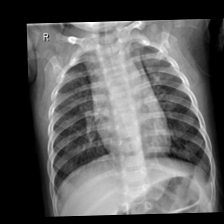

In [9]:
array_to_img(augmented_images[7])
#testing one image

In [10]:
print(len(X_train))
print(len(y_train))

5216
5216


### Concatenating the augmented images with the training set in order to offset the class imbalance

In [11]:
X_train = np.concatenate([X_train, augmented_images], axis = 0)
y_train = np.concatenate([y_train, [0 for i in augmented_images]], axis = 0)

In [12]:
print(len(X_train))
print(len(y_train))

6556
6556


In [13]:
X_train.shape

(6556, 224, 224, 3)

### Creating a simple baseline CNN model with 2 Convolution layers, 1 densely connected and no regularization

In [20]:
#baseline model- two convolution layers, maxpooling, one 32 node dense layer and the output

cnn = models.Sequential()

# Input convolution layer
cnn.add(layers.Conv2D(64, kernel_size= (3, 3), activation='relu', input_shape=(224, 224,  3)))

# Max pooling layer
cnn.add(layers.MaxPooling2D((2, 2)))

# Hidden convolution layer and pool
cnn.add(layers.Conv2D(32, kernel_size= (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))

# Output
cnn.add(layers.Dense(1, activation='sigmoid'))

# Compiling with stochastic gradient descent, optimized for accuracy
cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [21]:
cnn1 = cnn.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=50,
                    validation_data=(X_val, y_val))

Epoch 1/5
132/132 [==============================] - 178s 1s/step - loss: 0.5541 - acc: 0.7392 - val_loss: 1.2060 - val_acc: 0.5000
Epoch 2/5
132/132 [==============================] - 170s 1s/step - loss: 0.3797 - acc: 0.8336 - val_loss: 0.9682 - val_acc: 0.5625
Epoch 3/5
132/132 [==============================] - 172s 1s/step - loss: 0.2880 - acc: 0.8832 - val_loss: 0.7182 - val_acc: 0.8125
Epoch 4/5
132/132 [==============================] - 169s 1s/step - loss: 0.2440 - acc: 0.9022 - val_loss: 0.3753 - val_acc: 0.8750
Epoch 5/5
132/132 [==============================] - 169s 1s/step - loss: 0.2105 - acc: 0.9141 - val_loss: 0.4035 - val_acc: 0.7500


In [22]:
results_test = cnn.evaluate(X_test, y_test)

20/20 [==============================] - 4s 191ms/step - loss: 0.5064 - acc: 0.7821


In [ ]:
# Confusion Matrix functions
def get_labels(fit_model, X, threshold):
    return [1 if x >= threshold else 0 for x in fit_model.predict(X)]
def get_false_positive(true, prediction):
    return [1 if (x == 0 and y == 1) else 0 for x,y in zip(true,prediction)]
def get_true_positive(true, prediction):
    return [1 if (x == 1 and y == 1) else 0 for x,y in zip(true,prediction)]
def get_false_negative(true, prediction):
    return [1 if (x == 1 and y == 0) else 0 for x,y in zip(true,prediction)]

In [ ]:
# Generating a confusion matrix from the model predictions

predictions = get_labels(cnn, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

Not bad for a baseline model, but we think we can improve a lot on this model.

## Creating a more optimized model

#### Next, we created a much more complex model. We expanded our metrics from just Accuracy to adding AUC and Recall. We changed our optimizer to Adam in order to reduce improve our learning rate. We created overlaps in our pools, added regularization layers and increased the number of graduated dense layers. We also calculated the inverse class frequency to further compensate for our class imbalance.

In [23]:
# calculate inverse 
pnue_frequency = sum(y_train)/len(y_train)
inv_pnue_frequency = 1/pnue_frequency
normal_frequency = (len(y_train)-sum(y_train))/len(y_train)
inv_normal_frequency = 1/normal_frequency
weights = {
    0: inv_normal_frequency,
    1: inv_pnue_frequency
    }

In [ ]:
np.random.seed(42)

# Setting an early stop feature
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

cnn2 = models.Sequential()
# Input convolution layers
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Overlapped pooling
cnn2.add(layers.MaxPooling2D((2, 3)))

# First hidden convolution layers and pool
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 3)))

# Second hidden convolution layers and pools
cnn2.add(layers.Conv2D(16, (6, 6), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 3)))

cnn2.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 3)))

# Flatten layer
cnn2.add(layers.Flatten())

# 3 Graduated densely connected layers with graduated regularization
cnn2.add(layers.Dense(64, activation='relu'))
cnn2.add(layers.Dropout(.5))
cnn2.add(layers.Dense(32, activation='relu'))
cnn2.add(layers.Dropout(.3))
cnn2.add(layers.Dense(16, activation='relu'))
cnn2.add(layers.Dropout(.1))

# Output layer
cnn2.add(layers.Dense(1, activation='sigmoid'))
cnn2.compile(loss='binary_crossentropy',
              optimizer= 'Adam',
              metrics=['acc', 'Recall', 'AUC'])

# Fitting the model with our additional class weight parameter
cnn3 = cnn2.fit(X_train, y_train,
               epochs=10,
               batch_size=50,
               validation_data = (X_val, y_val), 
               class_weight=weights,
               verbose=True,
               callbacks = callback)

In [ ]:
results_test2 = cnn2.evaluate(X_test, y_test)

In [ ]:
# Plotting the progress by epoch

graphs.plot_loss(cnn3.history)

In [ ]:
# Generating a confusion matrix from the model predictions

predictions = get_labels(cnn2, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

## Transfer Learning

Though our initial results are looking good, we decided to bring in some pre-trained models and try to use them in conjuction- both to get ideas about the architecture that could work the best for us and to possibly use a voting classifier to combine a variety of models for the best possible result.

### VGG16

In [ ]:
VGG16_model = VGG16(input_shape = (224, 224, 3), 
                    # Shape of our images
                    include_top = False, 
                    # Leave out the last fully connected layer
                    weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
#making the existing layers untrainable in order to preserve them

# Flatten the output layer to 1 dimension
x = layers.Flatten()(VGG16_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a second fully connected layer with 256 hidden units and ReLU activation
x = layers.Dense(256, activation='relu')(x)

# Dropout with a rate of 0.3
x = layers.Dropout(.3)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

vggmodel = tf.keras.models.Model(VGG16_model.input, x)

vggmodel.compile(optimizer = 'Adam', 
              loss = 'binary_crossentropy',
              metrics = ['acc', 'Recall', 'AUC'])

vgghist = vggmodel.fit(X_train, y_train, 
                       validation_data = (X_val, y_val), 
                       epochs = 25, 
                       batch_size=25, 
                       class_weight=weights, 
                       callbacks= callback)

In [ ]:
results_test3 = vggmodel.evaluate(X_test, y_test)

In [ ]:
#Plotting loss by epoch

graphs.plot_loss(vgghist.history)

In [ ]:
# Generating a confusion matrix from the model predictions

predictions = get_labels(vggmodel, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

### DenseNet121

In [ ]:
densebase = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='Max',
    classes=2,)

for layer in densebase.layers:
    layer.trainable = False

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Flatten the output layer to 1 dimension
a = layers.Flatten()(densebase.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
a = layers.Dense(512, activation='relu')(a)

# Add a dropout rate of 0.5
a = layers.Dropout(0.5)(a)

# Add a second fully connected layer with 256 hidden units and ReLU activation
a = layers.Dense(256, activation='relu')(a)

a = layers.Dropout(.3)(a)
# Add a final sigmoid layer for classification
a = layers.Dense(1, activation='sigmoid')(a)

densemodel = tf.keras.models.Model(densebase.input, a)

densemodel.compile(optimizer = 'Adam', loss = 'binary_crossentropy',metrics = ['acc', 'Recall', 'AUC'])

densehist = densemodel.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 25, batch_size=25, class_weight=weights)

In [ ]:
results_test4 = densemodel.evaluate(X_test, y_test)

In [ ]:
# Plotting loss by epoch

graphs.plot_loss(densehist.history)

In [ ]:
# Generating a confusion matrix from the model predictions

predictions = get_labels(densemodel, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

### MobileNetV2

In [ ]:
mobile = tf.keras.applications.MobileNetV2(
                input_shape=(224, 224, 3), 
                alpha=1.0, 
                include_top=False, 
                weights='imagenet',
                input_tensor=None, 
                pooling='max', 
                classes=2)

for layer in mobile.layers:
    layer.trainable = False

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Flatten the output layer to 1 dimension
a = layers.Flatten()(mobile.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
a = layers.Dense(512, activation='relu')(a)

# Add a dropout rate of 0.5
a = layers.Dropout(0.5)(a)

# Add a second fully connected layer with 256 hidden units and ReLU activation
a = layers.Dense(256, activation='relu')(a)

a = layers.Dropout(.3)(a)
# Add a final sigmoid layer for classification
a = layers.Dense(1, activation='sigmoid')(a)

mobilemodel = tf.keras.models.Model(mobile.input, a)

mobilemodel.compile(optimizer = 'Adam', loss = 'binary_crossentropy',metrics = ['acc', 'Recall', 'AUC'])

mobilehist = mobilemodel.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 20, batch_size=25, class_weight=weights)

In [ ]:
mobile_test = mobilemodel.evaluate(X_test, y_test)

In [ ]:
# Plotting loss by epoch

graphs.plot_loss(mobilehist.history)

In [ ]:
# Generating a confusion matrix from the model predictions

predictions = get_labels(mobilemodel, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)